# Advancing Chemical Safety Prediction: An Integrated GNN Framework with DFT-augmented Cyclic Compound Solution

- This code implements a GNN with global features.
- The code below was developed based on HoC data, and it can be readily applied to VP and FP simply by substituting the data, as they share the same format.

## 0. Import Libraries

In [1]:
from collections import OrderedDict
import tensorflow as tf
import nfp
from collections import namedtuple
from rdkit import Chem
from rdkit.Chem import AllChem
from nfp.preprocessing.mol_preprocessor import SmilesPreprocessor
from nfp.preprocessing.features import get_ring_size
import numpy as np
import tensorflow_addons as tfa
from tensorflow.keras import layers
import pandas as pd

## 1. Data Loading
### 1-1. Exploring Data Shape and Structure

In [9]:
data='HoC_230711.csv'
HoC_data=pd.read_csv(data)

<AxesSubplot:ylabel='Frequency'>

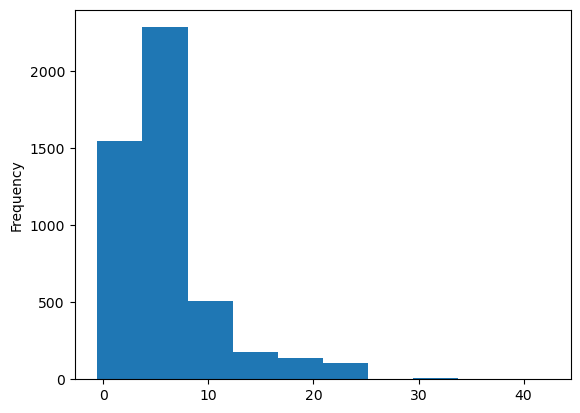

In [10]:
HoC_data.VALUE.plot.hist()

In [16]:
print(HoC_data.columns)

Index(['SMILES', 'Name', 'VALUE'], dtype='object')


In [11]:
print(HoC_data)

                                                 SMILES  \
0     CC(C)C1=CC2=CC[C@@H]3[C@](C)(CCC[C@@]3(C)C(O)=...   
1                                    C1Cc2cccc3cccc1c23   
2                                            CCOC(C)OCC   
3                                                  CC=O   
4                                               CC(N)=O   
...                                                 ...   
4775                           CCCCCCCCCCC1CCCc2ccccc12   
4776                        C1Cc2ccccc2C1.C3Cc4ccccc4C3   
4777                                     CC1Cc2ccccc2C1   
4778                                     Cc1cccc2CCCc12   
4779                                     Cc1ccc2CCCc2c1   

                                           Name     VALUE  
0                                  abietic acid  10.96053  
1                                  acenaphthene   6.01352  
2                                        acetal   3.56653  
3                                  acetaldehyde   1

### 1-2. Splitting Data

In [12]:
random_seed = 42
HoC_train = HoC_data.sample(frac=.8, random_state=random_seed)
HoC_valid = HoC_data[~HoC_data.index.isin(HoC_train.index)].sample(frac=.5, random_state=random_seed)
HoC_test = HoC_data[~HoC_data.index.isin(HoC_train.index) & ~HoC_data.index.isin(HoC_valid.index)]

## 2. Fitting GNN model

### 2-1. Hyperparameters tuning

In [19]:
# Define your hyperparameters to search over
BATCH_SIZES = [16, 32,64]
LAYERS_LIST = [1,2,3,4, 5, 6, 7]
NUM_FEATURES_LIST = [32, 64]

# Other fixed hyperparameters
LEARNING_RATE = 5.0e-5
EPOCHS = 20
GLOBAL_FEATURE_DIMS = 2

# Define namedtuples for atom and bond types
atom_type = namedtuple('Atom', ['symbol', 'aromatic', 'ring_size', 'degree', 'totalHs'])
bond_type = namedtuple('Bond', ['bond_type', 'degree', 'ring_size'])

# Define atom and bond featurizers
def atom_featurizer(atom):
    return atom_type(
        atom.GetSymbol(),
        atom.GetIsAromatic(),
        get_ring_size(atom, max_size=6),
        atom.GetDegree(),
        atom.GetTotalNumHs(includeNeighbors=True)
    )

def bond_featurizer(bond, flipped=False):
    if not flipped:
        atoms = "{}-{}".format(
            *tuple((bond.GetBeginAtom().GetSymbol(),
                    bond.GetEndAtom().GetSymbol())))
    else:
        atoms = "{}-{}".format(
            *tuple((bond.GetEndAtom().GetSymbol(),
                    bond.GetBeginAtom().GetSymbol())))
    
    btype = str(bond.GetBondType())
    ring = get_ring_size(bond, max_size=6) if bond.IsInRing() else None
    
    return bond_type(atoms, btype, ring)

# Define data generator function
def data_generator(preprocessor, data):
    for _, row in data.iterrows():
        inputs = preprocessor.construct_feature_matrices(row.SMILES, train=False)
        yield ({'atom': inputs['atom'],
                'bond': inputs['bond'],
                'connectivity': inputs['connectivity']},
               row.VALUE)


preprocessor = SmilesPreprocessor(
    atom_features=atom_featurizer,
    bond_features=bond_featurizer,
    explicit_hs=False)

for smiles in HoC_train.SMILES: 
  preprocessor.construct_feature_matrices(smiles, train=True)

output_signature = (preprocessor.output_signature,
                    tf.TensorSpec(shape=(), dtype=tf.float32))

# Initialize results storage
results = []

# Iterate over hyperparameters
for batch_size in BATCH_SIZES:
    for layers in LAYERS_LIST:
        for num_features in NUM_FEATURES_LIST:
            print(f"Testing batch_size={batch_size}, layers={layers}, num_features={num_features}")

            # Create datasets for train and validation
            train_dataset = tf.data.Dataset.from_generator(        
                lambda: data_generator(preprocessor, HoC_train), output_signature=output_signature)\
                .cache().shuffle(buffer_size=200)\
                .padded_batch(batch_size=batch_size)\
                .prefetch(tf.data.experimental.AUTOTUNE)
                
            valid_dataset = tf.data.Dataset.from_generator(        
                lambda: data_generator(preprocessor, HoC_valid), output_signature=output_signature)\
                .cache()\
                .padded_batch(batch_size=batch_size)\
                .prefetch(tf.data.experimental.AUTOTUNE)
                
            
            inputs, outputs = next(train_dataset.as_numpy_iterator())
            
                # Define model architecture
            atom = tf.keras.layers.Input(shape=[None], dtype=tf.int32, name='atom')
            bond = tf.keras.layers.Input(shape=[None], dtype=tf.int32, name='bond')
            connectivity = tf.keras.layers.Input(shape=[None, 2], dtype=tf.int32, name='connectivity')
                
            atom_state = tf.keras.layers.Embedding(preprocessor.atom_classes, num_features,
                                                       name='atom_embedding', mask_zero=True)(atom)
                
            bond_state = tf.keras.layers.Embedding(preprocessor.bond_classes, num_features,
                                                       name='bond_embedding', mask_zero=True)(bond)
                
            global_state = nfp.GlobalUpdate(units=8, num_heads=1)([atom_state, bond_state, connectivity])

            for _ in range(layers):
                new_bond_state = nfp.EdgeUpdate()([atom_state, bond_state, connectivity, global_state])
                bond_state = tf.keras.layers.Add()([bond_state, new_bond_state])
                
                new_atom_state = nfp.NodeUpdate()([atom_state, bond_state, connectivity, global_state])
                atom_state = tf.keras.layers.Add()([atom_state, new_atom_state])
                
                new_global_state = nfp.GlobalUpdate(units=8, num_heads=1)(
                    [atom_state, bond_state, connectivity, global_state]) 
                global_state = tf.keras.layers.Add()([global_state, new_global_state])
                
            mol_prediction = tf.keras.layers.Dense(1)(global_state)    
            input_tensors = [atom, bond, connectivity]
            
            model = tf.keras.Model([input_tensors], [mol_prediction])
            optimizer = tfa.optimizers.AdamW(learning_rate=LEARNING_RATE, weight_decay=1E-5)
            model.compile(optimizer, loss='mae')
                
            # Train the model
            hist = model.fit(train_dataset, validation_data=valid_dataset, epochs=EPOCHS, verbose=2)
             
            # Evaluate on validation set
            valid_results = model.predict(valid_dataset).squeeze()
            mae_valid = np.abs(valid_results - HoC_valid.VALUE).mean()
            
            # Store hyperparameters and average MAE
            results.append({
                'batch_size': batch_size,
                'layers': layers,
                'num_features': num_features,
                'mae_valid': mae_valid
            })

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)
print(results_df)

# Select best hyperparameters
best_hyperparameters = results_df.loc[results_df['mae_valid'].idxmin()]
batch_size = int(best_hyperparameters['batch_size'])
layers = int(best_hyperparameters['layers'])
num_features = int(best_hyperparameters['num_features'])

# Train the final model on the combined train and validation data with best hyperparameters
train_dataset_final = tf.data.Dataset.from_generator(        
    lambda: data_generator(preprocessor, HoC_train), output_signature=output_signature)\
    .cache()\
    .padded_batch(batch_size=batch_size)\
    .prefetch(tf.data.experimental.AUTOTUNE)

# Define model architecture with the best hyperparameters
atom_state = tf.keras.layers.Embedding(preprocessor.atom_classes, num_features,
                                       name='atom_embedding', mask_zero=True)(atom)
bond_state = tf.keras.layers.Embedding(preprocessor.bond_classes, num_features,
                                       name='bond_embedding', mask_zero=True)(bond)
global_state = nfp.GlobalUpdate(units=8, num_heads=1)([atom_state, bond_state, connectivity])

for _ in range(layers):
    new_bond_state = nfp.EdgeUpdate()([atom_state, bond_state, connectivity, global_state])
    bond_state = tf.keras.layers.Add()([bond_state, new_bond_state])
    new_atom_state = nfp.NodeUpdate()([atom_state, bond_state, connectivity, global_state])
    atom_state = tf.keras.layers.Add()([atom_state, new_atom_state])
    new_global_state = nfp.GlobalUpdate(units=8, num_heads=1)(
        [atom_state, bond_state, connectivity, global_state]) 
    global_state = tf.keras.layers.Add()([global_state, new_global_state])

mol_prediction = tf.keras.layers.Dense(1)(global_state)    
input_tensors = [atom, bond, connectivity]

model = tf.keras.Model([input_tensors], [mol_prediction])
optimizer = tfa.optimizers.AdamW(learning_rate=LEARNING_RATE, weight_decay=1E-5)
model.compile(optimizer, loss='mae')

# Train the final model on combined train and validation data
model.fit(train_dataset_final, epochs=EPOCHS, verbose=2)

# Evaluate the final model on test data
test_dataset = tf.data.Dataset.from_generator(        
    lambda: data_generator(preprocessor, HoC_test), output_signature=output_signature)\
    .cache()\
    .padded_batch(batch_size=batch_size)\
    .prefetch(tf.data.experimental.AUTOTUNE)

test_results = model.predict(test_dataset).squeeze()
mae_test = np.abs(test_results - HoC_test.VALUE).mean()
print(f"Final model evaluation on test data: MAE = {mae_test}")


Testing batch_size=16, layers=1, num_features=32
Epoch 1/20
239/239 - 9s - loss: 5.4374 - val_loss: 3.0153 - 9s/epoch - 38ms/step
Epoch 2/20
239/239 - 4s - loss: 2.3233 - val_loss: 2.1593 - 4s/epoch - 17ms/step
Epoch 3/20
239/239 - 4s - loss: 1.9331 - val_loss: 1.9791 - 4s/epoch - 17ms/step
Epoch 4/20
239/239 - 4s - loss: 1.7959 - val_loss: 1.8579 - 4s/epoch - 17ms/step
Epoch 5/20
239/239 - 4s - loss: 1.6882 - val_loss: 1.7575 - 4s/epoch - 16ms/step
Epoch 6/20
239/239 - 4s - loss: 1.5905 - val_loss: 1.7006 - 4s/epoch - 16ms/step
Epoch 7/20
239/239 - 4s - loss: 1.4922 - val_loss: 1.6011 - 4s/epoch - 17ms/step
Epoch 8/20
239/239 - 4s - loss: 1.3969 - val_loss: 1.4700 - 4s/epoch - 16ms/step
Epoch 9/20
239/239 - 4s - loss: 1.2988 - val_loss: 1.3651 - 4s/epoch - 17ms/step
Epoch 10/20
239/239 - 4s - loss: 1.2418 - val_loss: 1.3465 - 4s/epoch - 17ms/step
Epoch 11/20
239/239 - 4s - loss: 1.1744 - val_loss: 1.2856 - 4s/epoch - 17ms/step
Epoch 12/20
239/239 - 4s - loss: 1.1430 - val_loss: 1.2104

239/239 - 11s - loss: 0.3968 - val_loss: 0.5762 - 11s/epoch - 44ms/step
Epoch 16/20
239/239 - 10s - loss: 0.3871 - val_loss: 0.4124 - 10s/epoch - 44ms/step
Epoch 17/20
239/239 - 10s - loss: 0.3701 - val_loss: 0.4879 - 10s/epoch - 44ms/step
Epoch 18/20
239/239 - 11s - loss: 0.3538 - val_loss: 0.3653 - 11s/epoch - 44ms/step
Epoch 19/20
239/239 - 11s - loss: 0.3387 - val_loss: 0.3182 - 11s/epoch - 44ms/step
Epoch 20/20
239/239 - 11s - loss: 0.3147 - val_loss: 0.3873 - 11s/epoch - 44ms/step
30/30 [==============================] - 3s 17ms/step
Testing batch_size=16, layers=3, num_features=64
Epoch 1/20
239/239 - 33s - loss: 2.5766 - val_loss: 1.4365 - 33s/epoch - 138ms/step
Epoch 2/20
239/239 - 20s - loss: 1.1525 - val_loss: 1.1055 - 20s/epoch - 83ms/step
Epoch 3/20
239/239 - 19s - loss: 0.8585 - val_loss: 0.8332 - 19s/epoch - 81ms/step
Epoch 4/20
239/239 - 19s - loss: 0.7038 - val_loss: 0.7183 - 19s/epoch - 81ms/step
Epoch 5/20
239/239 - 20s - loss: 0.5689 - val_loss: 0.4963 - 20s/epoch -

Epoch 7/20
239/239 - 36s - loss: 0.3750 - val_loss: 0.6219 - 36s/epoch - 152ms/step
Epoch 8/20
239/239 - 36s - loss: 0.3667 - val_loss: 0.6276 - 36s/epoch - 152ms/step
Epoch 9/20
239/239 - 37s - loss: 0.3393 - val_loss: 0.3158 - 37s/epoch - 154ms/step
Epoch 10/20
239/239 - 37s - loss: 0.3218 - val_loss: 0.3949 - 37s/epoch - 156ms/step
Epoch 11/20
239/239 - 37s - loss: 0.3157 - val_loss: 0.4171 - 37s/epoch - 157ms/step
Epoch 12/20
239/239 - 38s - loss: 0.3068 - val_loss: 0.4207 - 38s/epoch - 157ms/step
Epoch 13/20
239/239 - 37s - loss: 0.2755 - val_loss: 0.3150 - 37s/epoch - 155ms/step
Epoch 14/20
239/239 - 38s - loss: 0.2910 - val_loss: 0.2717 - 38s/epoch - 157ms/step
Epoch 15/20
239/239 - 37s - loss: 0.2848 - val_loss: 0.3024 - 37s/epoch - 155ms/step
Epoch 16/20
239/239 - 37s - loss: 0.2718 - val_loss: 0.2464 - 37s/epoch - 153ms/step
Epoch 17/20
239/239 - 37s - loss: 0.2771 - val_loss: 0.2600 - 37s/epoch - 153ms/step
Epoch 18/20
239/239 - 37s - loss: 0.2571 - val_loss: 0.3516 - 37s/ep

Epoch 20/20
239/239 - 59s - loss: 0.2066 - val_loss: 0.2100 - 59s/epoch - 245ms/step
30/30 [==============================] - 5s 64ms/step
Testing batch_size=32, layers=1, num_features=32
Epoch 1/20
120/120 - 8s - loss: 6.0563 - val_loss: 5.9018 - 8s/epoch - 70ms/step
Epoch 2/20
120/120 - 4s - loss: 4.1731 - val_loss: 2.6246 - 4s/epoch - 30ms/step
Epoch 3/20
120/120 - 4s - loss: 2.2451 - val_loss: 2.1898 - 4s/epoch - 30ms/step
Epoch 4/20
120/120 - 4s - loss: 1.9795 - val_loss: 2.0312 - 4s/epoch - 30ms/step
Epoch 5/20
120/120 - 4s - loss: 1.8475 - val_loss: 1.9158 - 4s/epoch - 30ms/step
Epoch 6/20
120/120 - 4s - loss: 1.7430 - val_loss: 1.8260 - 4s/epoch - 30ms/step
Epoch 7/20
120/120 - 4s - loss: 1.6542 - val_loss: 1.7410 - 4s/epoch - 30ms/step
Epoch 8/20
120/120 - 4s - loss: 1.5773 - val_loss: 1.6538 - 4s/epoch - 31ms/step
Epoch 9/20
120/120 - 4s - loss: 1.4977 - val_loss: 1.5715 - 4s/epoch - 30ms/step
Epoch 10/20
120/120 - 4s - loss: 1.4179 - val_loss: 1.4803 - 4s/epoch - 30ms/step
E

120/120 - 10s - loss: 0.5877 - val_loss: 0.6171 - 10s/epoch - 81ms/step
Epoch 14/20
120/120 - 10s - loss: 0.5300 - val_loss: 0.5439 - 10s/epoch - 81ms/step
Epoch 15/20
120/120 - 10s - loss: 0.4736 - val_loss: 0.5094 - 10s/epoch - 80ms/step
Epoch 16/20
120/120 - 10s - loss: 0.4518 - val_loss: 0.5256 - 10s/epoch - 80ms/step
Epoch 17/20
120/120 - 10s - loss: 0.4638 - val_loss: 0.4657 - 10s/epoch - 82ms/step
Epoch 18/20
120/120 - 10s - loss: 0.4096 - val_loss: 0.5000 - 10s/epoch - 81ms/step
Epoch 19/20
120/120 - 10s - loss: 0.3989 - val_loss: 0.7024 - 10s/epoch - 80ms/step
Epoch 20/20
120/120 - 10s - loss: 0.4435 - val_loss: 0.4530 - 10s/epoch - 80ms/step
15/15 [==============================] - 2s 29ms/step
Testing batch_size=32, layers=3, num_features=64
Epoch 1/20
120/120 - 29s - loss: 3.7185 - val_loss: 2.0550 - 29s/epoch - 243ms/step
Epoch 2/20
120/120 - 18s - loss: 1.5286 - val_loss: 1.3363 - 18s/epoch - 150ms/step
Epoch 3/20
120/120 - 18s - loss: 1.0957 - val_loss: 1.0287 - 18s/epoc

Epoch 5/20
120/120 - 36s - loss: 0.4576 - val_loss: 0.6206 - 36s/epoch - 296ms/step
Epoch 6/20
120/120 - 35s - loss: 0.4359 - val_loss: 0.4579 - 35s/epoch - 296ms/step
Epoch 7/20
120/120 - 36s - loss: 0.3963 - val_loss: 0.5136 - 36s/epoch - 296ms/step
Epoch 8/20
120/120 - 35s - loss: 0.3655 - val_loss: 0.3524 - 35s/epoch - 292ms/step
Epoch 9/20
120/120 - 35s - loss: 0.3300 - val_loss: 0.3958 - 35s/epoch - 293ms/step
Epoch 10/20
120/120 - 35s - loss: 0.3033 - val_loss: 0.3635 - 35s/epoch - 292ms/step
Epoch 11/20
120/120 - 35s - loss: 0.3101 - val_loss: 0.2974 - 35s/epoch - 294ms/step
Epoch 12/20
120/120 - 35s - loss: 0.2772 - val_loss: 0.3065 - 35s/epoch - 293ms/step
Epoch 13/20
120/120 - 36s - loss: 0.2568 - val_loss: 0.2785 - 36s/epoch - 296ms/step
Epoch 14/20
120/120 - 35s - loss: 0.2842 - val_loss: 0.2621 - 35s/epoch - 294ms/step
Epoch 15/20
120/120 - 35s - loss: 0.2309 - val_loss: 0.3519 - 35s/epoch - 293ms/step
Epoch 16/20
120/120 - 35s - loss: 0.3240 - val_loss: 0.2956 - 35s/epoc

120/120 - 59s - loss: 0.2353 - val_loss: 0.2476 - 59s/epoch - 491ms/step
Epoch 18/20
120/120 - 59s - loss: 0.2235 - val_loss: 0.2532 - 59s/epoch - 492ms/step
Epoch 19/20
120/120 - 58s - loss: 0.2154 - val_loss: 0.2317 - 58s/epoch - 485ms/step
Epoch 20/20
120/120 - 58s - loss: 0.2574 - val_loss: 0.2870 - 58s/epoch - 485ms/step
15/15 [==============================] - 5s 127ms/step
Testing batch_size=64, layers=1, num_features=32
Epoch 1/20
60/60 - 7s - loss: 6.2284 - val_loss: 6.3161 - 7s/epoch - 115ms/step
Epoch 2/20
60/60 - 3s - loss: 5.9871 - val_loss: 5.9952 - 3s/epoch - 48ms/step
Epoch 3/20
60/60 - 3s - loss: 5.4777 - val_loss: 5.1627 - 3s/epoch - 48ms/step
Epoch 4/20
60/60 - 3s - loss: 3.7205 - val_loss: 2.8189 - 3s/epoch - 50ms/step
Epoch 5/20
60/60 - 3s - loss: 2.4745 - val_loss: 2.4377 - 3s/epoch - 58ms/step
Epoch 6/20
60/60 - 3s - loss: 2.1985 - val_loss: 2.1980 - 3s/epoch - 57ms/step
Epoch 7/20
60/60 - 4s - loss: 2.0100 - val_loss: 2.0533 - 4s/epoch - 60ms/step
Epoch 8/20
60/

Epoch 13/20
60/60 - 8s - loss: 0.6586 - val_loss: 0.7884 - 8s/epoch - 140ms/step
Epoch 14/20
60/60 - 8s - loss: 0.6723 - val_loss: 0.6994 - 8s/epoch - 140ms/step
Epoch 15/20
60/60 - 8s - loss: 0.6044 - val_loss: 0.6824 - 8s/epoch - 140ms/step
Epoch 16/20
60/60 - 9s - loss: 0.5796 - val_loss: 0.7308 - 9s/epoch - 144ms/step
Epoch 17/20
60/60 - 8s - loss: 0.5931 - val_loss: 0.6438 - 8s/epoch - 141ms/step
Epoch 18/20
60/60 - 8s - loss: 0.5396 - val_loss: 0.6034 - 8s/epoch - 139ms/step
Epoch 19/20
60/60 - 8s - loss: 0.5457 - val_loss: 0.5964 - 8s/epoch - 135ms/step
Epoch 20/20
60/60 - 7s - loss: 0.5127 - val_loss: 0.5998 - 7s/epoch - 122ms/step
8/8 [==============================] - 1s 45ms/step
Testing batch_size=64, layers=3, num_features=64
Epoch 1/20
60/60 - 21s - loss: 4.1332 - val_loss: 2.4617 - 21s/epoch - 344ms/step
Epoch 2/20
60/60 - 13s - loss: 1.9723 - val_loss: 1.8144 - 13s/epoch - 215ms/step
Epoch 3/20
60/60 - 13s - loss: 1.5480 - val_loss: 1.4865 - 13s/epoch - 223ms/step
Epoch

Epoch 7/20
60/60 - 21s - loss: 0.4681 - val_loss: 0.6821 - 21s/epoch - 343ms/step
Epoch 8/20
60/60 - 22s - loss: 0.5190 - val_loss: 0.4550 - 22s/epoch - 359ms/step
Epoch 9/20
60/60 - 22s - loss: 0.3797 - val_loss: 0.4542 - 22s/epoch - 362ms/step
Epoch 10/20
60/60 - 22s - loss: 0.4510 - val_loss: 0.4153 - 22s/epoch - 370ms/step
Epoch 11/20
60/60 - 22s - loss: 0.3409 - val_loss: 0.3889 - 22s/epoch - 370ms/step
Epoch 12/20
60/60 - 22s - loss: 0.3996 - val_loss: 0.3447 - 22s/epoch - 371ms/step
Epoch 13/20
60/60 - 22s - loss: 0.3680 - val_loss: 0.3891 - 22s/epoch - 372ms/step
Epoch 14/20
60/60 - 22s - loss: 0.3305 - val_loss: 0.4676 - 22s/epoch - 370ms/step
Epoch 15/20
60/60 - 22s - loss: 0.2876 - val_loss: 0.3745 - 22s/epoch - 366ms/step
Epoch 16/20
60/60 - 22s - loss: 0.3513 - val_loss: 0.3075 - 22s/epoch - 371ms/step
Epoch 17/20
60/60 - 22s - loss: 0.3246 - val_loss: 0.3765 - 22s/epoch - 370ms/step
Epoch 18/20
60/60 - 22s - loss: 0.2992 - val_loss: 0.4190 - 22s/epoch - 373ms/step
Epoch 1

In [18]:
best_hyperparameters

batch_size      16.00000
layers           7.00000
num_features    64.00000
mae_valid        0.33519
Name: 13, dtype: float64

## 2-2. Final GNN model fitting using the Best Hyperparameters

### 2-2-1. Dataset summary

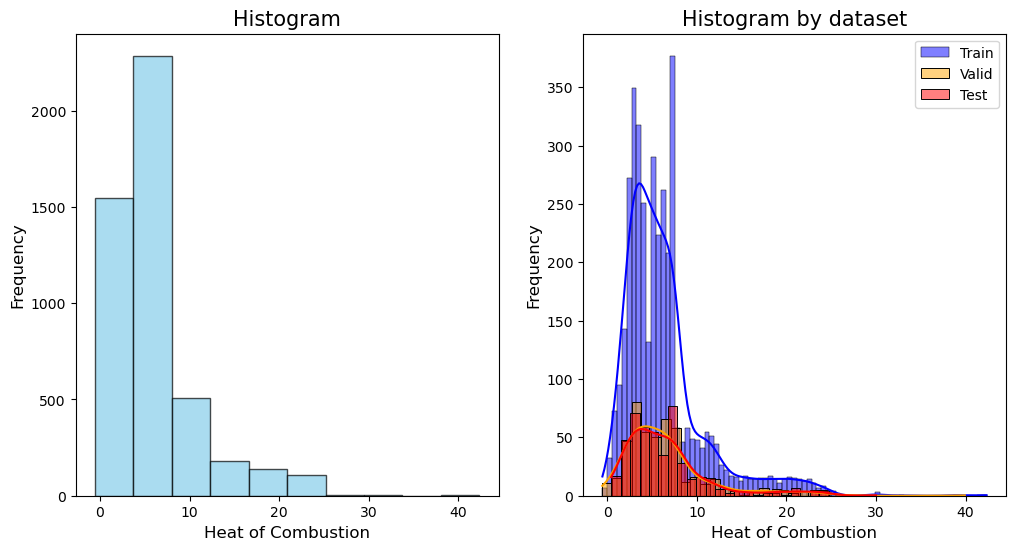

<Figure size 1200x600 with 0 Axes>

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].hist(HoC_data['VALUE'], bins=10, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Histogram', fontsize=15)
axes[0].set_xlabel('Heat of Combustion', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)



plt.figure(figsize=(12, 6))
sns.histplot(HoC_train['VALUE'], color='blue', label='Train', kde=True, ax=axes[1])
sns.histplot(HoC_valid['VALUE'], color='orange', label='Valid', kde=True, ax=axes[1])
sns.histplot(HoC_test['VALUE'], color='red', label='Test', kde=True, ax=axes[1])
axes[1].set_title('Histogram by dataset', fontsize=15)
axes[1].set_xlabel('Heat of Combustion', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].legend()


plt.tight_layout()
plt.show()

### 2-2-2. Model training

Epoch 1/100
120/120 - 20s - loss: 1.8148 - val_loss: 0.9658 - 20s/epoch - 169ms/step
Epoch 2/100
120/120 - 9s - loss: 0.8843 - val_loss: 1.1557 - 9s/epoch - 74ms/step
Epoch 3/100
120/120 - 9s - loss: 0.6629 - val_loss: 0.5378 - 9s/epoch - 72ms/step
Epoch 4/100
120/120 - 9s - loss: 0.5507 - val_loss: 0.5051 - 9s/epoch - 71ms/step
Epoch 5/100
120/120 - 9s - loss: 0.4543 - val_loss: 0.5129 - 9s/epoch - 71ms/step
Epoch 6/100
120/120 - 9s - loss: 0.4595 - val_loss: 0.3643 - 9s/epoch - 71ms/step
Epoch 7/100
120/120 - 8s - loss: 0.4044 - val_loss: 0.4299 - 8s/epoch - 67ms/step
Epoch 8/100
120/120 - 8s - loss: 0.3565 - val_loss: 0.3903 - 8s/epoch - 68ms/step
Epoch 9/100
120/120 - 8s - loss: 0.3136 - val_loss: 0.4436 - 8s/epoch - 68ms/step
Epoch 10/100
120/120 - 8s - loss: 0.3104 - val_loss: 0.5439 - 8s/epoch - 66ms/step
Epoch 11/100
120/120 - 8s - loss: 0.2831 - val_loss: 0.3726 - 8s/epoch - 68ms/step
Epoch 12/100
120/120 - 8s - loss: 0.2618 - val_loss: 0.2798 - 8s/epoch - 67ms/step
Epoch 13/1

Epoch 100/100
120/120 - 9s - loss: 0.1463 - val_loss: 0.1531 - 9s/epoch - 75ms/step


<AxesSubplot:>

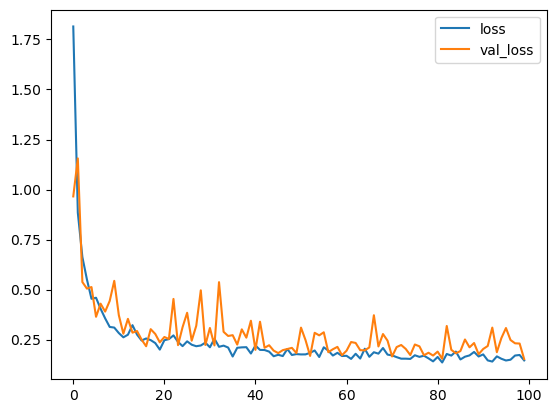

In [21]:
import random
# set random seed
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

batch_size = 32
layers = 6
num_features = 64
LEARNING_RATE = 0.0001

EPOCHS=100


# Define namedtuples for atom and bond types
atom_type = namedtuple('Atom', ['symbol', 'aromatic', 'ring_size', 'degree', 'totalHs'])
bond_type = namedtuple('Bond', ['bond_type', 'degree', 'ring_size'])

# Define atom and bond featurizers
def atom_featurizer(atom):
    return atom_type(
        atom.GetSymbol(),
        atom.GetIsAromatic(),
        get_ring_size(atom, max_size=6),
        atom.GetDegree(),
        atom.GetTotalNumHs(includeNeighbors=True)
    )

def bond_featurizer(bond, flipped=False):
    if not flipped:
        atoms = "{}-{}".format(
            *tuple((bond.GetBeginAtom().GetSymbol(),
                    bond.GetEndAtom().GetSymbol())))
    else:
        atoms = "{}-{}".format(
            *tuple((bond.GetEndAtom().GetSymbol(),
                    bond.GetBeginAtom().GetSymbol())))
    
    btype = str(bond.GetBondType())
    ring = get_ring_size(bond, max_size=6) if bond.IsInRing() else None
    
    return bond_type(atoms, btype, ring)

# Define data generator function
def data_generator(preprocessor, data):
    for _, row in data.iterrows():
        inputs = preprocessor.construct_feature_matrices(row.SMILES, train=False)
        yield ({'atom': inputs['atom'],
                'bond': inputs['bond'],
                'connectivity': inputs['connectivity']},
               row.VALUE)


preprocessor = SmilesPreprocessor(
    atom_features=atom_featurizer,
    bond_features=bond_featurizer,
    explicit_hs=False)

for smiles in HoC_train.SMILES: 
  preprocessor.construct_feature_matrices(smiles, train=True)

output_signature = (preprocessor.output_signature,
                    tf.TensorSpec(shape=(), dtype=tf.float32))

train_dataset = tf.data.Dataset.from_generator(        
    lambda: data_generator(preprocessor, HoC_train), output_signature=output_signature)\
    .cache().shuffle(buffer_size=200)\
    .padded_batch(batch_size=batch_size)\
    .prefetch(tf.data.experimental.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_generator(        
    lambda: data_generator(preprocessor, HoC_valid), output_signature=output_signature)\
    .cache()\
    .padded_batch(batch_size=batch_size)\
    .prefetch(tf.data.experimental.AUTOTUNE)

train_dataset_final = tf.data.Dataset.from_generator(        
    lambda: data_generator(preprocessor, HoC_train), output_signature=output_signature)\
    .cache()\
    .padded_batch(batch_size=batch_size)\
    .prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(        
    lambda: data_generator(preprocessor, HoC_test), output_signature=output_signature)\
    .cache()\
    .padded_batch(batch_size=batch_size)\
    .prefetch(tf.data.experimental.AUTOTUNE)

inputs, outputs = next(train_dataset.as_numpy_iterator())

# Define model architecture
atom = tf.keras.layers.Input(shape=[None], dtype=tf.int32, name='atom')
bond = tf.keras.layers.Input(shape=[None], dtype=tf.int32, name='bond')
connectivity = tf.keras.layers.Input(shape=[None, 2], dtype=tf.int32, name='connectivity')

atom_state = tf.keras.layers.Embedding(preprocessor.atom_classes, num_features,
                                       name='atom_embedding', mask_zero=True)(atom)
bond_state = tf.keras.layers.Embedding(preprocessor.bond_classes, num_features,
                                       name='bond_embedding', mask_zero=True)(bond)
global_state = nfp.GlobalUpdate(units=8, num_heads=1)([atom_state, bond_state, connectivity])

for _ in range(layers):
    new_bond_state = nfp.EdgeUpdate()([atom_state, bond_state, connectivity, global_state])
    bond_state = tf.keras.layers.Add()([bond_state, new_bond_state])
    new_atom_state = nfp.NodeUpdate()([atom_state, bond_state, connectivity, global_state])
    atom_state = tf.keras.layers.Add()([atom_state, new_atom_state])
    new_global_state = nfp.GlobalUpdate(units=8, num_heads=1)(
        [atom_state, bond_state, connectivity, global_state]) 
    global_state = tf.keras.layers.Add()([global_state, new_global_state])

mol_prediction = tf.keras.layers.Dense(1)(global_state)    
input_tensors = [atom, bond, connectivity]

model = tf.keras.Model([input_tensors], [mol_prediction])
optimizer = tfa.optimizers.AdamW(learning_rate=LEARNING_RATE, weight_decay=1E-5)
model.compile(optimizer, loss='mae')

# Train the final model on combined train and validation data
hist = model.fit(train_dataset,  validation_data=valid_dataset, epochs=EPOCHS, verbose=2)

pd.DataFrame(hist.history).plot.line()




In [22]:
# Evaluate on validation set
train_results = model.predict(train_dataset_final).squeeze()
valid_results = model.predict(valid_dataset).squeeze()
test_results = model.predict(test_dataset).squeeze()

mae_train = np.abs(train_results - HoC_train.VALUE).mean()
mae_valid = np.abs(valid_results - HoC_valid.VALUE).mean()
mae_test = np.abs(test_results - HoC_test.VALUE).mean()

15/15 [==============================] - 1s 34ms/step


In [23]:
print(mae_train)
print(mae_valid)
print(mae_test)

0.10249480360245479
0.1530753598194554
0.1258967247686745


In [24]:
from sklearn.metrics import r2_score

# R2 
r2_train = r2_score(HoC_train.VALUE, train_results)
r2_valid = r2_score(HoC_valid.VALUE, valid_results)
r2_test = r2_score(HoC_test.VALUE, test_results)

# print : MAE
print(f"MAE Train: {mae_train}")
print(f"MAE Valid: {mae_valid}")
print(f"MAE Test: {mae_test}")

# print : R2
print(f"R2 Train: {r2_train}")
print(f"R2 Valid: {r2_valid}")
print(f"R2 Test: {r2_test}")

MAE Train: 0.10249480360245479
MAE Valid: 0.1530753598194554
MAE Test: 0.1258967247686745
R2 Train: 0.9935103531218614
R2 Valid: 0.9893332900491579
R2 Test: 0.9925522041968375


### 2-2-3. Residual Visualization and Outlier Detection

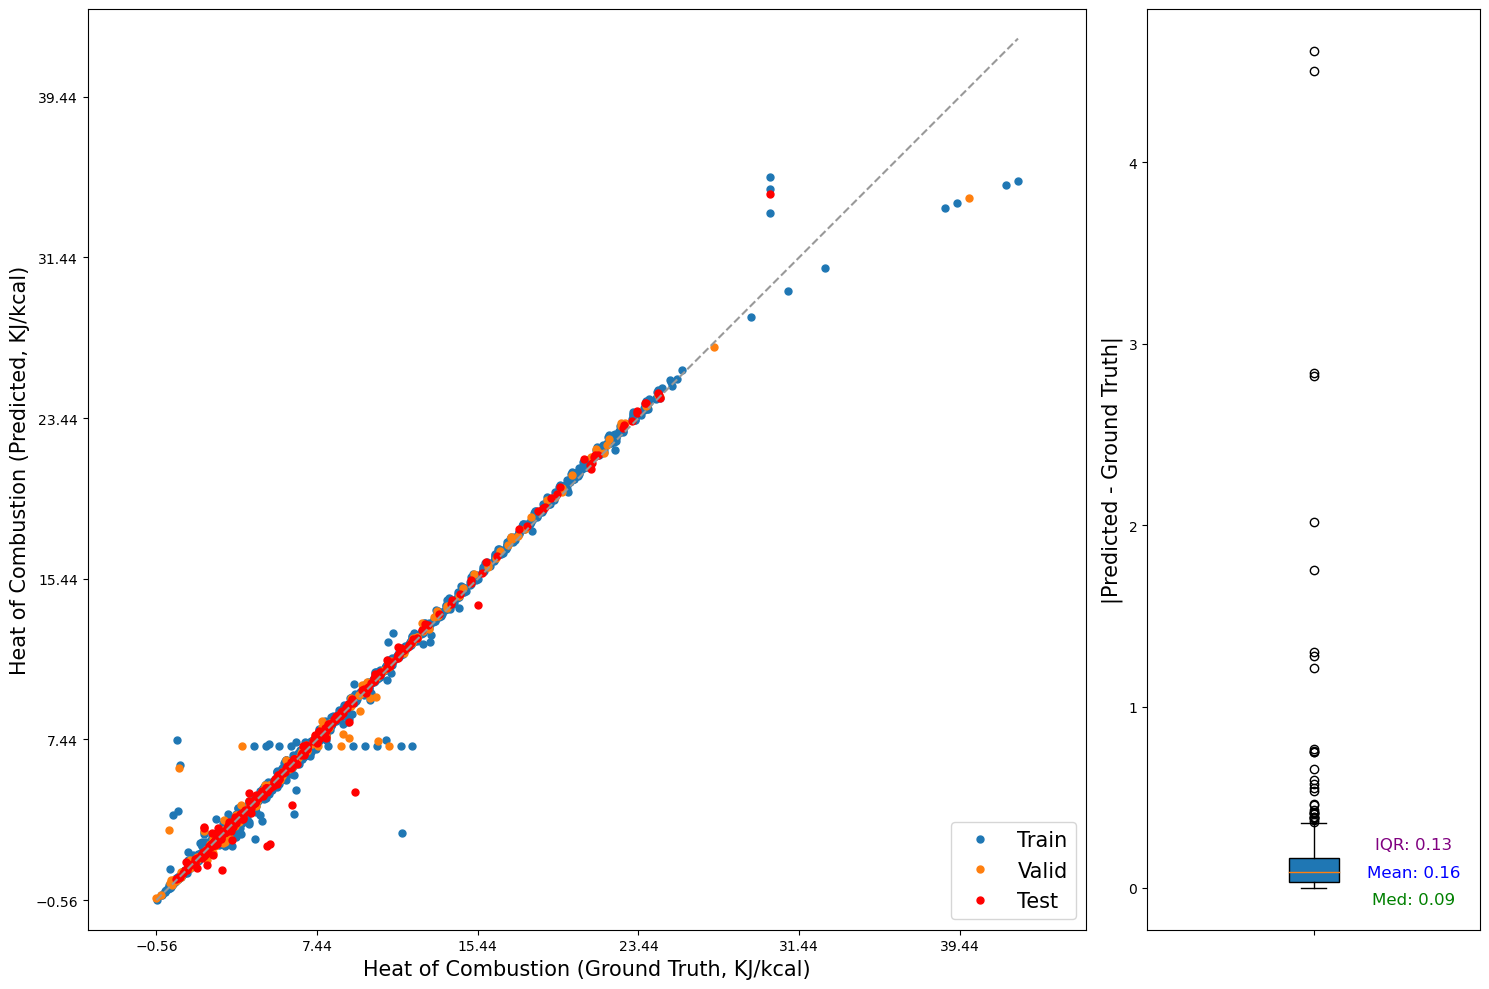

In [85]:
import matplotlib.pyplot as plt

test_residuals_abs = np.abs(HoC_test['VALUE'] - test_results)
test_residuals_abs_series = pd.Series(test_residuals_abs, index=HoC_test.index)

# calculate IQR
Q1 = np.percentile(test_residuals_abs, 25)
Q3 = np.percentile(test_residuals_abs, 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = test_residuals_abs_series[(test_residuals_abs_series < lower_bound) | (test_residuals_abs_series > upper_bound)]

outlier_data = HoC_test.loc[outliers.index]

fig, axs = plt.subplots(1, 2, figsize=(15, 10), gridspec_kw={'width_ratios': [3, 1]})

# First subplot: Predicted vs Actual values
axs[0].axis('equal')
axs[0].set_xticks(np.arange(min(HoC_data.VALUE), max(HoC_data.VALUE), (max(HoC_data.VALUE)-min(HoC_data.VALUE))//5))
axs[0].set_yticks(np.arange(min(HoC_data.VALUE), max(HoC_data.VALUE), (max(HoC_data.VALUE)-min(HoC_data.VALUE))//5))    
axs[0].set_xlabel('Heat of Combustion (Ground Truth, KJ/kcal)', fontsize=15)
axs[0].set_ylabel('Heat of Combustion (Predicted, KJ/kcal)', fontsize=15)
axs[0].plot(HoC_train['VALUE'], train_results, '.', ms=10, label='Train')
axs[0].plot(HoC_valid['VALUE'], valid_results, '.', ms=10, label='Valid')    
axs[0].plot(HoC_test['VALUE'], test_results, '.',  ms=10, label='Test', color="red")
axs[0].legend(loc='lower right', fontsize=15)
axs[0].plot([min(HoC_data.VALUE), max(HoC_data.VALUE)], [min(HoC_data.VALUE), max(HoC_data.VALUE)], '--', color='.6')

# Second subplot: Box plot of absolute residuals
box = axs[1].boxplot(test_residuals_abs, patch_artist=True)
axs[1].set_title('', fontsize=15)
axs[1].set_ylabel('|Predicted - Ground Truth|', fontsize=15)
axs[1].set_xticklabels([''])

# Display additional information on the box plot such as mean and median
mean = np.mean(test_residuals_abs)
median = np.median(test_residuals_abs)

# Adjust text position
mean_offset = 1.5
median_offset = 1.5

axs[1].text(1.3, mean - 0.1, f'Mean: {mean:.2f}', ha='center', color='blue', fontsize=12, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
axs[1].text(1.3, mean - 0.25, f'Med: {median:.2f}', ha='center', color='green', fontsize=12, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

axs[1].text(1.3, Q3+0.05, f'IQR: {IQR:.2f}', ha='center', color='purple', fontsize=12, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

plt.tight_layout()
plt.show()

### 2-2-4. Outlier

In [79]:
outlier_data

,SMILES,Name,VALUE
260,CCCCN=C=O,butyl isocyanate,2.513950
600,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC(Br)Br,"1,1-dibromononatriacontane",23.763630
853,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC(F)F,"1,1-difluorodotriacontane",19.067120
876,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC(F)F,"1,1-difluorooctatriacontane",22.733960
995,CC(C)CCCCCCCOC(=O)c1ccccc1C(=O)OCCCCCCCC(C)C,diisodecyl phthalate,15.450080
1570,Cc1c(cccc1[N+]([O-])=O)[N+]([O-])=O,"2,6-dinitrotoluene",1.805940
1571,Cc1ccc(c(c1)[N+]([O-])=O)[N+]([O-])=O,"3,4-dinitrotoluene",1.805940
1585,C1COCCO1,"1,4-dioxane",2.189000
1625,CCCCCCCCCCCNCCCCCCCCCCC,diundecylamine,11.489100
1673,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC#C,1-dotriacontyne,19.528190
